# Live Detection

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfU1oqUelihOo5LSXUTJqkEBqfE7u6R-Z2i_U7XnTjmueg?download=1 -O waste_classification.hdf5

In [8]:
import re
import os
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
net = tf.keras.models.load_model(os.path.join("waste_classification.hdf5"))

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


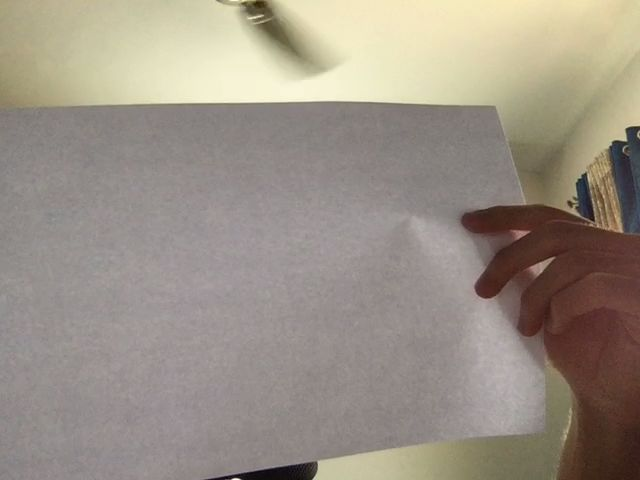

In [11]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [12]:
def class_id_to_label(id):
    label_map = {1: 'glass', 3: 'paper', 0: 'cardboard', 4: 'plastic', 2: 'metal', 5: 'trash'}
    return label_map[id]

In [13]:
im = cv2.imread('photo.jpg')
im_net = np.expand_dims(im, axis=0)
print(im_net.shape)

pred = net.predict(im_net)
# print(pred.shape)
# print(pred)
pred_label = np.argmax(pred, axis=1)
# print(pred_label.shape)
label = class_id_to_label(pred_label[0])
label

(1, 480, 640, 3)


'cardboard'

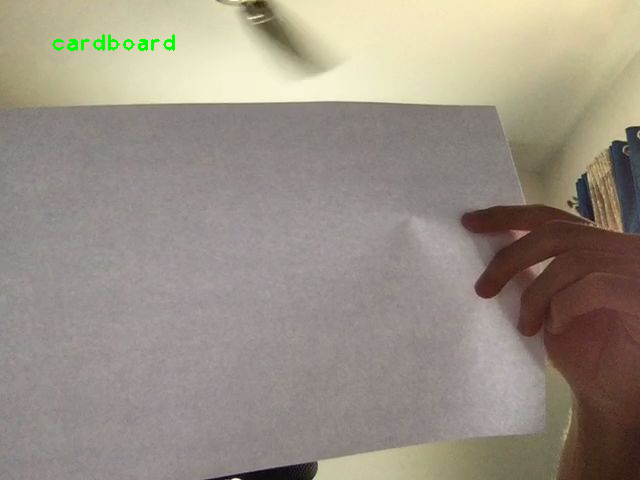

In [14]:
cv2.putText(im, label, (50, 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)
cv2_imshow(im)

In [19]:
def live_classification(img_path):
    try:
      filename = take_photo(img_path)
      print('Saved to {}'.format(filename))
      
      # Show the image which was just taken.
      # display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

    im = cv2.imread('photo.jpg')
    im_net = np.expand_dims(im, axis=0)
    print(im_net.shape)

    pred = net.predict(im_net)
    # print(pred.shape)
    # print(pred)
    pred_label = np.argmax(pred, axis=1)
    # print(pred_label.shape)
    label = class_id_to_label(pred_label[0])
    # label
    cv2.putText(im, label, (50, 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)
    cv2_imshow(im)

<IPython.core.display.Javascript object>

Saved to photo.jpg
(1, 480, 640, 3)


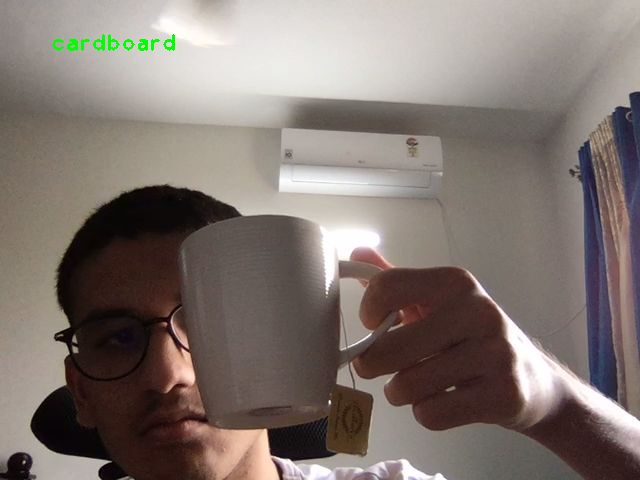

In [20]:
live_classification("photo.jpg")

# Data:
https://www.kaggle.com/asdasdasasdas/garbage-classification

# Model inspired from:
https://www.kaggle.com/mtszkw/garbage-keras-90-at-first-run-no-preprocessing

In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
import json

kaggle_dict = {"username":"nikhilnanda","key":"83a7f4389ccf1ed79c5d553e4c3f1446"}
  
with open("kaggle.json", "w") as outfile:
    json.dump(kaggle_dict, outfile)

In [3]:
!ls

kaggle.json  sample_data


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [5]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

 90% 74.0M/82.0M [00:03<00:00, 17.4MB/s]
100% 82.0M/82.0M [00:03<00:00, 26.3MB/s]


In [6]:
!unzip -q garbage-classification.zip

In [7]:
import re
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def list_dataset():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

            
# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    

IMAGES_DIR = '/content/Garbage classification/Garbage classification/'
    
train_file = '/content/one-indexed-files-notrash_train.txt'
val_file   = '/content/one-indexed-files-notrash_val.txt'
test_file  = '/content/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 328 samples.


In [8]:
df_train.head()

,rel_path,label
0,cardboard/cardboard202.jpg,cardboard
1,paper/paper472.jpg,paper
2,paper/paper522.jpg,paper
3,glass/glass189.jpg,glass
4,glass/glass325.jpg,glass


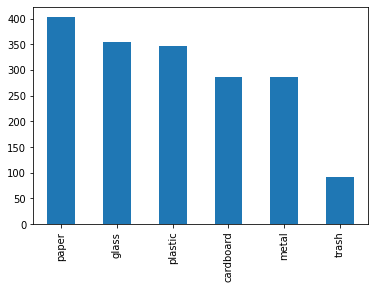

In [9]:
df_train["label"].value_counts().plot.bar()

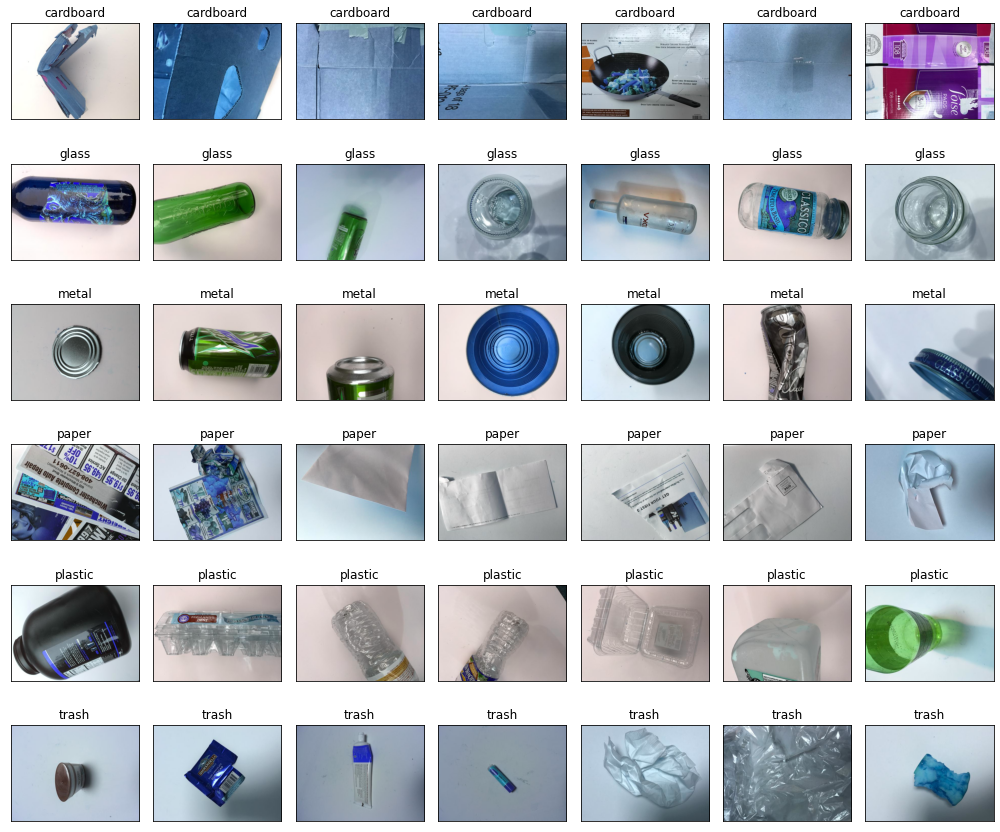

In [10]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df_train.label.unique()):
    for j in range(7):
        path = df_train[df_train.label==label].rel_path.iloc[k]
        path = IMAGES_DIR + path
        # print(path)
        im = cv2.imread(path)
        # print(im)
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
        plt.tight_layout()

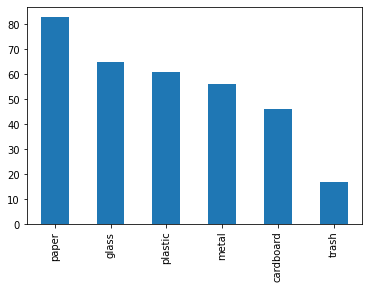

In [11]:
df_valid["label"].value_counts().plot.bar()

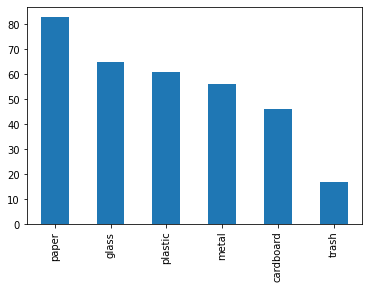

In [12]:
df_test["label"].value_counts().plot.bar()

In [13]:
datagen = ImageDataGenerator()

datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


## Model

In [14]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


net = build_model(num_classes=6)

net.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

net.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

## Training

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

os.makedirs("models", exist_ok=True)
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_categorical_accuracy",
    verbose=0,
    save_best_only=True)

history = net.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=30,
    validation_freq=1,
    callbacks=[checkpointer, early_stop]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
56/56 [==============================] - 55s 371ms/step - loss: 1.4933 - categorical_accuracy: 0.6121 - val_loss: 0.6097 - val_categorical_accuracy: 0.7774
Epoch 2/30
56/56 [==============================] - 19s 331ms/step - loss: 0.3585 - categorical_accuracy: 0.8672 - val_loss: 0.4076 - val_categorical_accuracy: 0.8659
Epoch 3/30
56/56 [==============================] - 19s 331ms/step - loss: 0.1988 - categorical_accuracy: 0.9382 - val_loss: 0.3492 - val_categorical_accuracy: 0.8902
Epoch 4/30
56/56 [==============================] - 19s 331ms/step - loss: 0.1520 - categorical_accuracy: 0.9528 - val_loss: 0.3210 - val_categorical_accuracy: 0.8902
Epoch 5/30
56/56 [==============================] - 18s 329ms/step - loss: 0.0986 - categorical_accuracy: 0.9690 - val_loss: 0.3007 - val_categorical_accuracy: 0.8872
Epoch 6/30
56/56 [==============================] - 19s 330ms/step - loss: 0.0454 - categorical_accuracy: 0.9908 - val_loss: 0.2860 - val_categorical_accuracy: 0.887

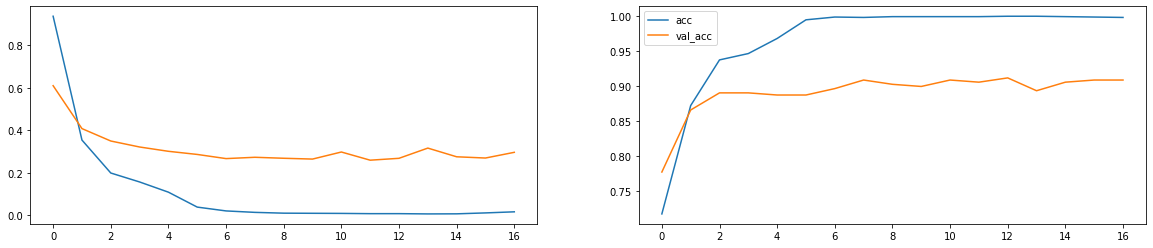

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['categorical_accuracy'], label='acc')
axs[1].plot(history.history['val_categorical_accuracy'], label='val_acc')

plt.legend();
plt.show();

In [17]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

# y_pred = net.predict(test_generator, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

net = tf.keras.models.load_model(os.path.join("models", "weights.hdf5"))

net.evaluate_generator(test_generator, nb_samples)

Found 328 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.26774466037750244, 0.9115853905677795]

In [18]:
test_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [19]:
yhat_test = net.predict(test_generator)

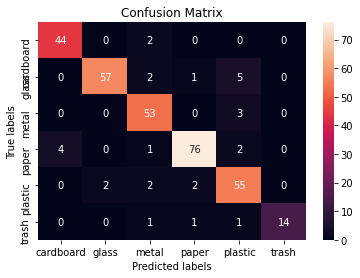

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cm = confusion_matrix(y_true, y_pred)


cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(yhat_test, axis=1))
# f = sns.heatmap(cm, annot=True)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])
ax.yaxis.set_ticklabels(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']);

In [21]:
def class_id_to_label(id):
    label_map = {1: 'glass', 3: 'paper', 0: 'cardboard', 4: 'plastic', 2: 'metal', 5: 'trash'}
    return label_map[id]

In [22]:
df_test[df_test.label=='plastic'].rel_path.iloc[5]

'plastic/plastic421.jpg'

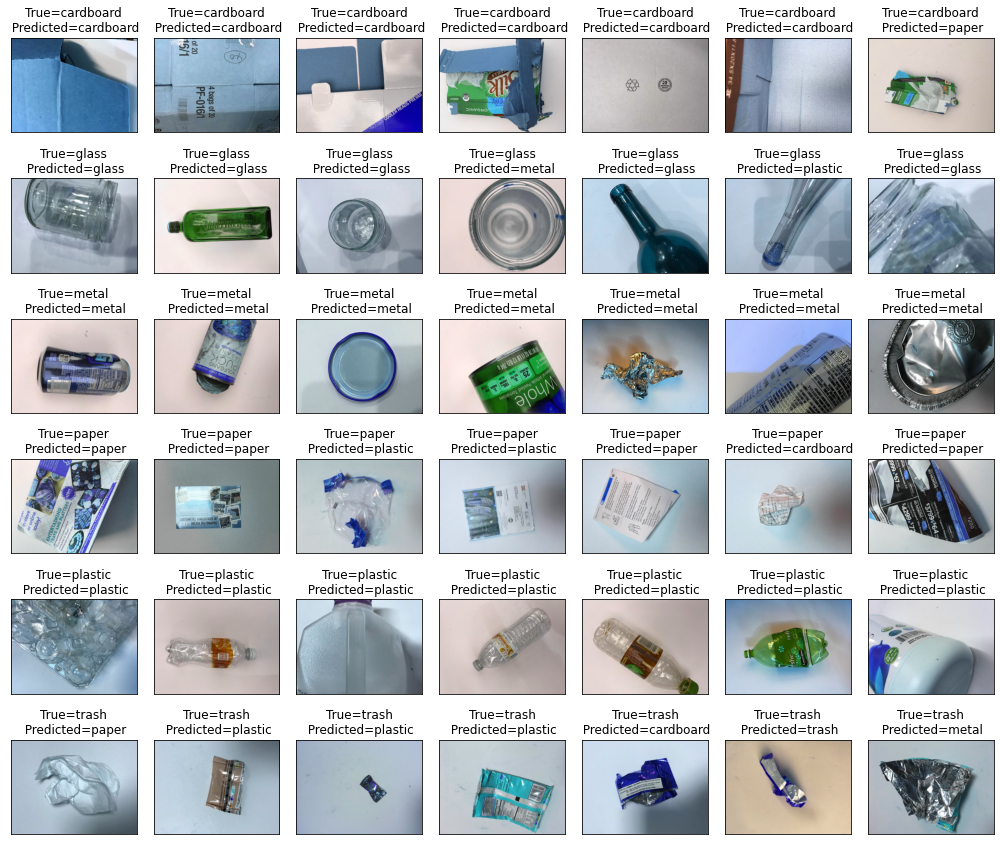

In [23]:
fig = plt.figure(1, (14, 14))

k = 0
l = 0
for label in sorted(df_test.label.unique()):
    l = 0
    for j in range(7):
        # print(df_test[df_test.label==label].rel_path.iloc[k], k)
        path = df_test[df_test.label==label].rel_path.iloc[l]
        path = IMAGES_DIR + path
        # print(path)
        im = cv2.imread(path)
        im_net = np.expand_dims(im, axis=0)
        # print(im_net.shape)

        pred = net.predict(im_net)
        pred_label = np.argmax(pred, axis=1)
        # print(pred_label)
        k += 1
        l += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title("True="+str(label)+"\n Predicted="+str(pred_label))
        # class_id_to_label
        ax.set_title("True="+str(label)+"\n Predicted="+class_id_to_label(pred_label[0]))
        plt.tight_layout()